# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
pre_URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [3]:
pre_indeed = requests.get(pre_URL)

In [4]:
pre_soup = BeautifulSoup(pre_indeed.content, "lxml")

Run cell below to see what text-only results look like (in markdown; switch to code first):

pre_count = 0
for i in pre_soup.findAll('div', class_ = '  row result'):
    print pre_count, i.text
    print '\n'
    pre_count += 1

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [6]:
def get_jobtitle(result):
    '''This function constructs a list containing each job title.'''
    jobtitle_list = []
    for i in result.findAll('a', class_ = 'jobtitle turnstileLink'): 
        jobtitle_list.append(str(i.text.encode('utf8')))
    return jobtitle_list

def get_location(result):
    '''This function constructs a list containing each job location.'''
    location_list = []
    for i in result.findAll('span', class_ = 'location'):
        location_list.append(str(i.text.encode('utf8')))
    return location_list

def get_company(result):   
    '''This function constructs a list containing each job company.'''
    company_list = []
    for i in result.findAll('span', class_ = 'company'):
        company = str(i.text.encode('utf8'))
        company = company.replace('\n', '')
        company = company.replace('    ', '')
        company_list.append(company)
    return company_list
    
def get_salary(result):
    '''This function constructs a list containing each job salary.'''
    salary_list = []
    for i in result.findAll('td', class_ = 'snip'):
        if i.find('nobr') != None:
            salary_list.append(i.find('nobr').text)
        else:
            salary_list.append('NaN')
    return salary_list

def putitalltogether(result):
    '''This function creates a dataframe whose columns are the lists produced by the functions it contains.'''
    jobs = get_jobtitle(result)
    locations = get_location(result)
    companies = get_company(result)
    salaries = get_salary(result)
    return pd.DataFrame(zip(jobs, locations, companies, salaries),\
                        columns = ['title', 'location', 'company', 'salary']) 

Let's see what putitalltogether does with pre_soup:

In [7]:
putitalltogether(pre_soup)

,title,location,company,salary
0,Data Scientist,"New York, NY","AbilTo, Inc",NaN
1,Data Scientist – Predictive Analytics,"New York, NY",Gallup,NaN
2,"Sr. Data Scientist, Learning Services","New York, NY",Chegg,NaN
3,Research Data Analyst,"New York, NY",Brilliant Leap,$800 a day
4,Junior Data Scientist,"New York, NY",DEPT OF ENVIRONMENT PROTECTION,"$47,839 - $70,058 a year"


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

Let's scrape Indeed.com 'Data Scientist' job listings in the top 25 most populous cities in the United States (https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population).  Let's also increase maximum number of search results per city to 1000.

In [ ]:
url_template = ['http://www.indeed.com/jobs?q=data+scientist&l=', '&start=']

max_results_per_city = 1000

##### Create empty dataframe with the columns we want; concatenate to it the new one generated for each city
df = pd.DataFrame(columns=['title', 'location', 'company', 'salary', 'city', 'state'])

for city in set(['New+York,+NY', 'Los+Angeles,+CA', 'Chicago,+IL', 'Houston,+TX', 'Philadelphia,+PA', 'Phoenix,+AZ', \
'San+Antonio,+TX', 'San+Diego,+CA', 'Dallas,+TX', 'San+Jose,+CA', 'Austin,+TX', 'Jacksonville,+FL', 'San+Francisco,+CA',\
'Indianapolis,+IN', 'Columbus,+OH', 'Fort+Worth,+TX', 'Charlotte,+NC', 'Seattle,+WA', 'Denver,+CO', 'El+Paso,+TX', \
'Detroit,+MI', 'Washington,+DC', 'Boston,+MA', 'Memphis,+TN', 'Nashville,+TN']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        URL = url_template[0] + city + url_template[1] + str(start)
        indeed = requests.get(URL)
        soup = BeautifulSoup(indeed.content, "lxml")
        # Append to the full set of results and 
        x = putitalltogether(soup)
        nice_city = city.split(',')
        state = nice_city[1]
        state = state.replace('+', '')
        nice_city = nice_city[0]
        nice_city = nice_city.replace('+', ' ')
        x['city'] = nice_city
        x['state'] = state
        df = pd.concat([x, df], axis = 0)          

The cell below loads .csv file of a scrape done using code above ^

In [9]:
df = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-04/starter-code/IndeedSalaryData2_rough.csv')

In [10]:
df.head(1)

,Unnamed: 0,title,location,company,salary,city,state
0,0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,NaN,Detroit,MI


In [11]:
df['salary'] = df['salary'].apply(lambda x: str(x))
df['salary'] = df['salary'].apply(lambda x: str(x.replace('nan', 'NaN')))
df = df[['title', 'location', 'company', 'salary', 'city', 'state']]

Each city's dataframe has its own index which remains unchanged following concatenation, so let's reset the main index now:

In [12]:
df = df.reset_index(drop = True)
df.head(1)

,title,location,company,salary,city,state
0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,NaN,Detroit,MI


Of the maximum number of observations we could have received from this scrape, what percentage did we actually get?

In [13]:
float(len(df)) / (25*1000 + len(df))

0.4159151441521424

In [14]:
df.dtypes

title       object
location    object
company     object
salary      object
city        object
state       object
dtype: object

In [15]:
df.to_csv('IndeedSalaryData2_rough.csv', encoding='utf-8')

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [16]:
print 'Total number of listings: %s' %len(df) 
print 'Listings with non-\'NaN\' salary entries: %s' %len(df[df['salary'] != 'NaN'])
print 'Percentage with non-\'NaN\' salary entries: %s' %(float(len(df[df['salary'] != 'NaN']))/len(df))

Total number of listings: 17802
Listings with non-'NaN' salary entries: 492
Percentage with non-'NaN' salary entries: 0.0276373441186


In [17]:
print 'Of all salary entries:'
print '\n'
print '%s are per month;' %len(df[df['salary'].str.contains('month')]) 
print '%s are per week;' %len(df[df['salary'].str.contains('week')])
print '%s are per hour;' %len(df[df['salary'].str.contains('hour')])
print '%s are per day.' %len(df[df['salary'].str.contains('day')])
print '\n'
print 'Delete all of these.'

Of all salary entries:


264 are per month;
2 are per week;
19 are per hour;
3 are per day.


Delete all of these.


In [18]:
df = df[df['salary'].str.contains('month') == False]
df = df[df['salary'].str.contains('week') == False]
df = df[df['salary'].str.contains('hour') == False]
df = df[df['salary'].str.contains('day') == False]

In [19]:
print 'Of %s' %len(df[df['salary'] != 'NaN']) +' non-\'NaN\' salary entries, %s' \
%len(df[df['salary'].str.contains('year')]) +' are explicitly labeled as yearly.'

Of 204 non-'NaN' salary entries, 204 are explicitly labeled as yearly.


This cell prints any remaining non-'NaN' salary entries which are not explicitly labeled as yearly:

In [20]:
if (-len(df[df['salary'].str.contains('year')]) + (len(df[df['salary'] != 'NaN']))) != 0:
    print 'The %s' %(-len(df[df['salary'].str.contains('year')]) + (len(df[df['salary'] != 'NaN']))) +' which are not \
explicitly labeled as yearly salaries are the following:'
    print df[(df['salary'] != 'NaN') & (df['salary'].str.contains('year') == False)]
else:
    print '(None)'

(None)


How many data types are represented in the column entries for df['salary']?  These will need to get parsed and changed to float type.

In [21]:
def num_cat(x):
    '''This function returns a set containing all data types contained in the argument provided.'''
    cat_list = []
    for i in x:
        cat_list.append(type(i))
    return set(cat_list)

In [22]:
num_cat(df['salary'])

{str}

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [23]:
def parse_salary(df):
    '''This function takes a dataframe argument containing a column 'salary' and creates a new column, \
    'parsed_salary', with corresponding float entries (which are the average of a range, if and when provided).'''
    parsed_salary = []
    for i in df['salary']:
        if i == 'NaN':
            parsed_salary.append(i)
        elif i != 'NaN':
            x = str(i)
            if '-' in x:
                x = x.split('-')
                x[0] = x[0].replace('$', '')
                x[0] = x[0].replace(',', '')
                x[0] = x[0].replace(' ', '')
                x[1] = x[1].replace('$', '')
                x[1] = x[1].replace(',', '')
                x2 = x[1].split(' ')
                x[1] = x2[1]
                new_x = (float(x[0]) + float(x[1]))/2
                parsed_salary.append(new_x)   
            elif '$' in x:
                z = x.split(' ')
                z = z[0]
                z = z.replace('$', '')
                z = z.replace(',', '')
                parsed_salary.append(float(z))
            else:
                parsed_salary.append('delete_me')
    df['parsed_salary'] = parsed_salary
    df = df[df['parsed_salary'].str.contains('delete_me') == False]
    return 

Examine modified dataframe to ensure 'city', 'state', and 'parsed_salary' columns appear:

In [24]:
parse_salary(df)
df.head()

,title,location,company,salary,city,state,parsed_salary
0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,NaN,Detroit,MI,NaN
1,Data Scientist,"Dearborn, MI",Ciber,NaN,Detroit,MI,NaN
2,Data Scientist Engineer,"Farmington Hills, MI",Mango Languages,NaN,Detroit,MI,NaN
3,Data Analytical Scientist,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI,NaN
4,Descriptive Analytics - Data Scientist,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI,NaN


See what non-'NaN' 'parsed_salary' entries look like:

In [25]:
df[df['parsed_salary'] != 'NaN'].head()

,title,location,company,salary,city,state,parsed_salary
612,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,"$120,000 - $150,000 a year",Boston,MA,135000
637,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,"$100,000 - $150,000 a year",Boston,MA,125000
642,"Data Scientist, Machine Learning Engineer","Boston, MA 02116 (South End area)",Fanning Personnel,"$80,000 - $125,000 a year",Boston,MA,102500
690,Data Scientist – Predictive Analytics,"Burlington, MA",Workbridge Associates,"$100,000 - $145,000 a year",Boston,MA,122500
724,Data Scientist – Predictive Analytics,"Boston, MA",Workbridge Associates,"$65,000 - $85,000 a year",Boston,MA,75000


In [26]:
df.to_csv('IndeedSalaryData2.csv', encoding='utf-8')

## Predicting salaries using Logistic Regression

#### Load in the data of scraped salaries

In [27]:
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as st
import re
import sklearn
from sklearn import linear_model as lm
from sklearn import cross_validation, preprocessing
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import matplotlib.patheffects as path_effects
from sklearn.metrics import mean_squared_error

% matplotlib inline

In [28]:
df_new = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-04/starter-code/IndeedSalaryData2.csv')
df_new = df_new[['title', 'location', 'company', 'city', 'state', 'parsed_salary']]
df_new.head(1)

,title,location,company,city,state,parsed_salary
0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,Detroit,MI,NaN


In [29]:
df_new.dtypes

title             object
location          object
company           object
city              object
state             object
parsed_salary    float64
dtype: object

Create a new dataframe which contains only observations whose 'parsed_salary' entries are numerical:

In [30]:
#sal_df = df_new[df_new['parsed_salary'] != 'NaN']
sal_df = df_new[df_new['parsed_salary'] >= 0]
sal_df = sal_df.reset_index(drop = True)
print len(sal_df)
sal_df.head(1)

204


,title,location,company,city,state,parsed_salary
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0


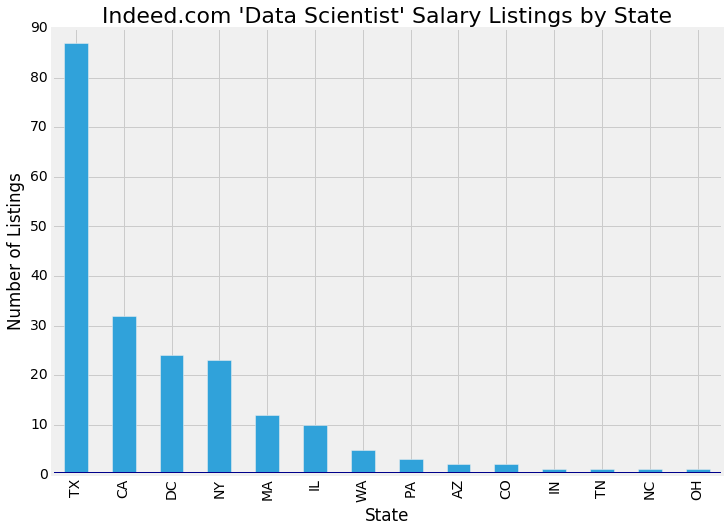

In [31]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

states = sal_df['state'].value_counts()

states.plot.bar()

plt.axhline(0, color='darkblue')

plt.title('Indeed.com \'Data Scientist\' Salary Listings by State', fontsize = 22)

# y label
plt.ylabel('Number of Listings')

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
# x label
plt.xlabel('State')

#plt.legend(loc='upper right', fontsize = 15)

plt.show()

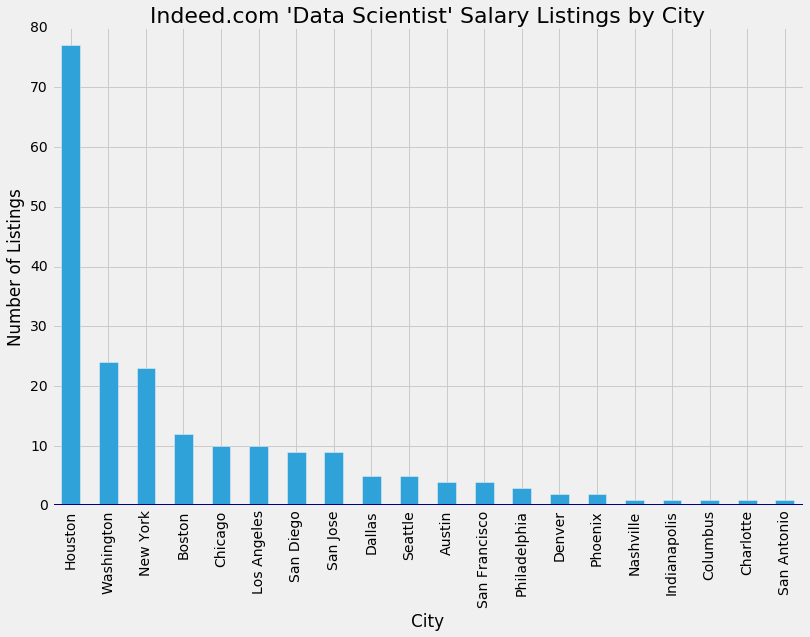

In [32]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

cities = sal_df['city'].value_counts()

cities.plot.bar()

plt.axhline(0, color='darkblue')

plt.title('Indeed.com \'Data Scientist\' Salary Listings by City', fontsize = 22)

# y label
plt.ylabel('Number of Listings')

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
# x label
plt.xlabel('City')

#plt.legend(loc='upper right', fontsize = 15)

plt.show()

Wow!  What's going on in Houston?  Let's see:

In [33]:
sal_df[sal_df['city'] == 'Houston'].head()

,title,location,company,city,state,parsed_salary
69,Software Development Engineer – New AWS Machin...,"Houston, TX 77042 (West Houston area)",Burnett Specialists,Houston,TX,77500.0
70,Project Associate,"Houston, TX 77042 (West Houston area)",Burnett Specialists,Houston,TX,77500.0
71,Software Development Engineer – New AWS Machin...,"Houston, TX 77042 (West Houston area)",Burnett Specialists,Houston,TX,77500.0
72,Software Development Engineer – New AWS Machin...,"Houston, TX 77042 (West Houston area)",Burnett Specialists,Houston,TX,77500.0
73,Software Development Engineer – New AWS Machin...,"Houston, TX 77042 (West Houston area)",Burnett Specialists,Houston,TX,77500.0


In [34]:
len(sal_df[sal_df['company'] == 'Burnett Specialists'])

74

Looks like 'Burnett Specialists' is a recruiting agency; let's get rid of those observations since salary data is the same for all 74 of them and is obviously going to skew our median salary.  Then, let's investigate what the parsed salaries look like:

In [35]:
sal_df = sal_df[sal_df['company'] != 'Burnett Specialists']

In [36]:
print 'The minimum salary listed is %s' %min(sal_df['parsed_salary'])
sal_df[sal_df['parsed_salary'] == min(sal_df['parsed_salary'])]

The minimum salary listed is 15000.0


,title,location,company,city,state,parsed_salary
183,Data Scientist – Predictive Analytics,"Falls Church, VA",Smith Arnold Partners,Washington,DC,15000.0


In [37]:
print 'The maximum salary listed is %s' %max(sal_df['parsed_salary'])
sal_df[sal_df['parsed_salary'] == max(sal_df['parsed_salary'])]

The maximum salary listed is 250000.0


,title,location,company,city,state,parsed_salary
148,"Software Development Engineer, Big Data- Reloc...","Philadelphia, PA",Averity,Philadelphia,PA,250000.0


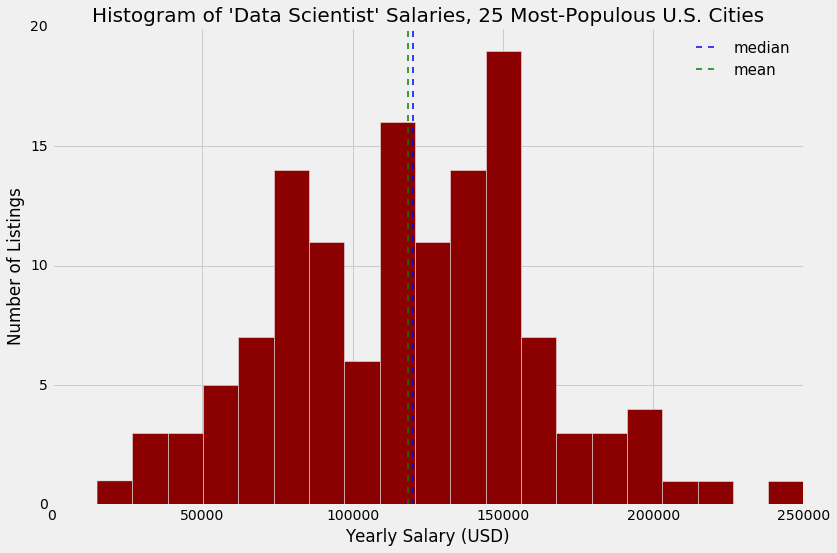

In [38]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(sal_df['parsed_salary'], color = 'darkred', bins = 20)
plt.axvline(sal_df['parsed_salary'].median(), color='b', linestyle='dashed', linewidth=1.5, label = 'median')
plt.axvline(sal_df['parsed_salary'].mean(), color='g', linestyle='dashed', linewidth=1.5, label = 'mean')

plt.title('Histogram of \'Data Scientist\' Salaries, 25 Most-Populous U.S. Cities', fontsize = 20)

# y label
plt.ylabel('Number of Listings')

# x label
plt.xlabel('Yearly Salary (USD)')

plt.xlim([0, max(sal_df['parsed_salary'])])
#plt.ylim([-10, 85])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

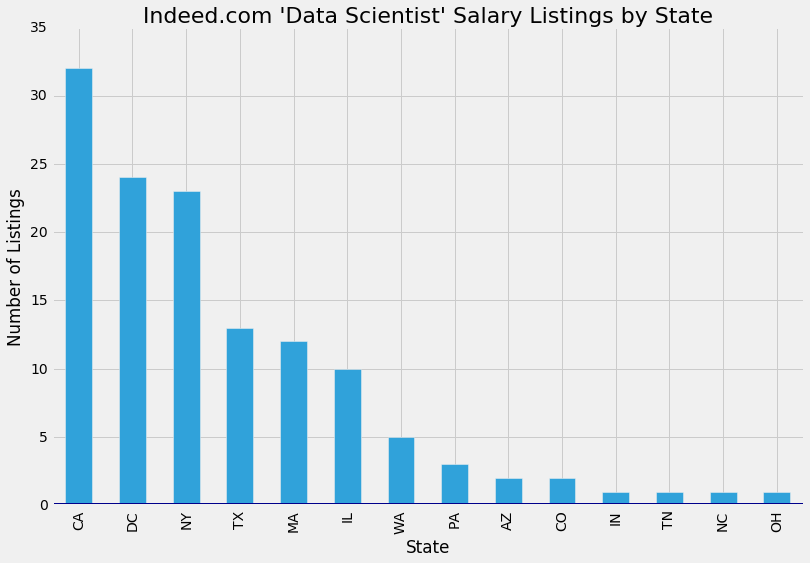

In [39]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

states = sal_df['state'].value_counts()

states.plot.bar()

plt.axhline(0, color='darkblue')

plt.title('Indeed.com \'Data Scientist\' Salary Listings by State', fontsize = 22)

# y label
plt.ylabel('Number of Listings')

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
# x label
plt.xlabel('State')

#plt.legend(loc='upper right', fontsize = 15)

#plt.show()

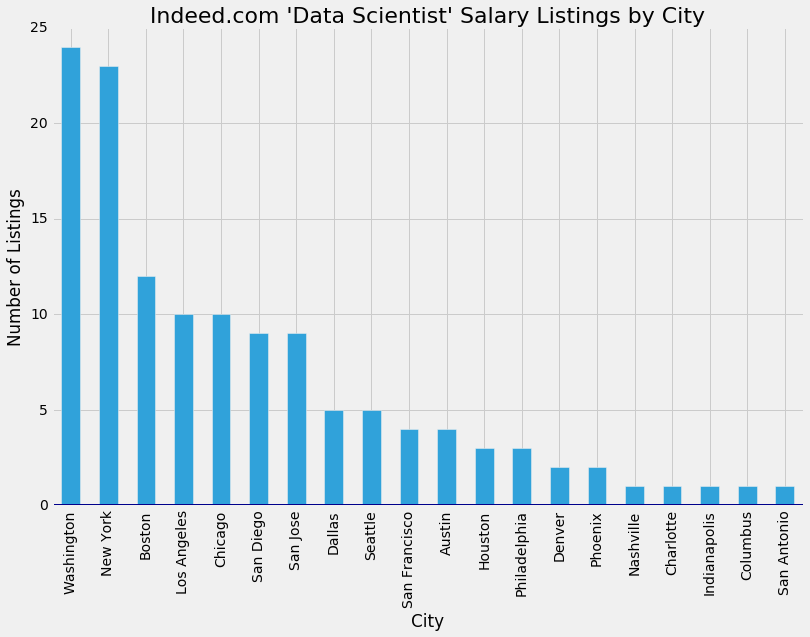

In [40]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

cities = sal_df['city'].value_counts()

cities.plot.bar()

plt.axhline(0, color='darkblue')

plt.title('Indeed.com \'Data Scientist\' Salary Listings by City', fontsize = 22)

# y label
plt.ylabel('Number of Listings')

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
# x label
plt.xlabel('City')

#plt.legend(loc='upper right', fontsize = 15)

plt.show()

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [41]:
sal_df.dtypes

title             object
location          object
company           object
city              object
state             object
parsed_salary    float64
dtype: object

(If cell below throws an error, uncomment first line and run again.)

In [42]:
#sal_df['parsed_salary'] = sal_df['parsed_salary'].apply(lambda x: float(x))
sal_df['parsed_salary'].describe()

count       130.000000
mean     118325.550000
std       42916.225347
min       15000.000000
25%       85578.375000
50%      120000.000000
75%      145000.000000
max      250000.000000
Name: parsed_salary, dtype: float64

In [43]:
median = float(sal_df['parsed_salary'].describe().loc['50%'])
print 'The median salary is %s.' %median

The median salary is 120000.0.


Create new column of salary dummy variable where 1 is above median and 0 is below median salary:

In [44]:
def sal_dummify(x):
    sal_dummy = []
    for i in sal_df['parsed_salary']:
        if i > median:
            sal_dummy.append(1)
        elif i <= median:
            sal_dummy.append(0)
        # This shouldn't happen, but just in case...
        else:
            sal_dummy.append('NaN')
    x['sal_dummy'] = sal_dummy
    return x

In [45]:
sal_dummify(sal_df)
sal_df['sal_dummy'].value_counts()

0    66
1    64
Name: sal_dummy, dtype: int64

In [46]:
sal_df.head(2)

,title,location,company,city,state,parsed_salary,sal_dummy
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1
1,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,Boston,MA,125000.0,1


In [47]:
print 'There are %s cities' %len(sal_df['city'].unique()) + ' and %s states represented in the dataframe.'\
%len(sal_df['state'].unique())
print '\n'
print 'There are %s cities' %len(df['city'].unique()) + ' and %s states represented in the original, scraped data.'\
%len(df['state'].unique())

There are 20 cities and 14 states represented in the dataframe.


There are 25 cities and 16 states represented in the original, scraped data.


In [48]:
sal_df['state'].value_counts()

CA    32
DC    24
NY    23
TX    13
MA    12
IL    10
WA     5
PA     3
AZ     2
CO     2
IN     1
TN     1
NC     1
OH     1
Name: state, dtype: int64

Let's add a column for state income tax rate (http://taxfoundation.org/article/state-individual-income-tax-rates-and-brackets-2016):

In [49]:
tax_dict = {
    'TX':0,
    'CA':13.3,
    'DC':8.95,
    'NY':8.82,
    'MA':5.1,
    'IL':3.75,
    'WA':0,
    'PA':3.07,
    'AZ':4.54,
    'CO':4.63,
    'IN':3.3,
    'TN':6.0,
    'NC':5.75,
    'OH':4.997
}

In [50]:
sal_df['inc_tax_rate'] = sal_df['state'].map(tax_dict)

In [51]:
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy,inc_tax_rate
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1,5.1


#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

First, do a logistic regression with dummy variables according to cities:

In [52]:
sal_df['city'].value_counts()

Washington       24
New York         23
Boston           12
Los Angeles      10
Chicago          10
San Diego         9
San Jose          9
Dallas            5
Seattle           5
San Francisco     4
Austin            4
Houston           3
Philadelphia      3
Denver            2
Phoenix           2
Nashville         1
Charlotte         1
Indianapolis      1
Columbus          1
San Antonio       1
Name: city, dtype: int64

In [53]:
X_city = pd.DataFrame(sal_df['city'])
X_city['intercept'] = 1
X_city = pd.concat([X_city.drop('city',axis=1), pd.get_dummies(X_city['city'])], axis = 1)
y = sal_df['sal_dummy']

Drop one of the dummy variables (just pick first one on the left):

In [54]:
X_city.drop('Austin', axis=1, inplace=True)
X_city.head(1)

,intercept,Boston,Charlotte,Chicago,Columbus,Dallas,Denver,Houston,Indianapolis,Los Angeles,Nashville,New York,Philadelphia,Phoenix,San Antonio,San Diego,San Francisco,San Jose,Seattle,Washington
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
model_city = st.MNLogit(y, X_city)

In [56]:
model_city_fit = model_city.fit(method = 'bfgs')

         Current function value: 0.618502
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [57]:
model_city_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      110
Method:                           MLE   Df Model:                           19
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                  0.1075
Time:                        12:02:51   Log-Likelihood:                -80.405
converged:                      False   LL-Null:                       -90.094
                                        LLR p-value:                    0.4329
=================================================================================
  sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
intercept        -0.3467      1.015     -0.342      0.733        -2.336     1.643
Boston           -0.1484      1.177     -0.126      0.900        -2.455     2.158
Charlotte         2.8394      3.900      0.728      0.467        -4.804    10.482
Chicago           1.2030      1.228      0.980      0.327        -1.204     3.610
Columbus         -2.5873      4.678     -0.553      0.580       -11.757     6.582
Dallas            0.0518      1.359      0.038      0.970        -2.613     2.716
Denver            0.2852      1.741      0.164      0.870        -3.128     3.698
Houston          -0.7396      1.673     -0.442      0.658        -4.018     2.538
Indianapolis     -2.5873      4.678     -0.553      0.580       -11.757     6.582
Los Angeles      -0.0439      1.202     -0.037      0.971        -2.401     2.313
Nashville         2.8394      3.900      0.728      0.467        -4.804    10.482
New York          0.3276      1.097      0.299      0.765        -1.823     2.478
Philadelphia     -0.7396      1.673     -0.442      0.658        -4.018     2.538
Phoenix          -3.9444      6.210     -0.635      0.525       -16.115     8.226
San Antonio      -2.5873      4.678     -0.553      0.580       -11.757     6.582
San Diego         2.3940      1.459      1.641      0.101        -0.465     5.253
San Francisco     1.9136      1.667      1.148      0.251        -1.355     5.182
San Jose          0.2134      1.215      0.176      0.861        -2.168     2.595
Seattle           0.0518      1.359      0.038      0.970        -2.613     2.716
Washington        0.1122      1.095      0.102      0.918        -2.034     2.259
=================================================================================
"""

In [58]:
### aic and bic ###
print 'AIC: %s' %model_city_fit.aic
print 'BIC: %s' %model_city_fit.bic

AIC: 200.810414044
BIC: 258.161103053


In [59]:
lsvc = LinearSVC(C=0.12, penalty="l1", dual=False).fit(X_city, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_city)
sal_df[X_new == 1]['city'].unique()

array(['Boston', 'Los Angeles', 'Charlotte', 'San Diego', 'San Jose',
       'Nashville', 'Austin', 'New York', 'Houston', 'Philadelphia',
       'Chicago', 'Denver', 'Seattle', 'Indianapolis', 'Phoenix', 'Dallas',
       'San Francisco', 'San Antonio', 'Columbus', 'Washington'], dtype=object)

In [60]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X_city, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_city)
sal_df[X_new == 1]['city'].unique()

array(['San Diego'], dtype=object)

In [61]:
np.exp(2.394)

10.957235343292794

Performing L1-based feature selection on the model cities model, we see that San Diego is the most significant in determining salary status in relation to median salary.  The odds of a salary in San Diego being above median over the odds of a salary in Austin being above median is nearly 11.

In [62]:
X_SanDiego = X_city['San Diego']
y = sal_df['sal_dummy']
model_SanDiego = st.MNLogit(y, X_SanDiego)
model_SanDiego_fit = model_SanDiego.fit(method = 'bfgs')
model_SanDiego_fit.summary()

Optimization terminated successfully.
         Current function value: 0.669310
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      129
Method:                           MLE   Df Model:                            0
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                 0.03422
Time:                        12:02:52   Log-Likelihood:                -87.010
converged:                       True   LL-Null:                       -90.094
                                        LLR p-value:                       nan
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
San Diego       2.0794      1.061      1.961      0.050         0.001     4.158
===============================================================================
"""

In [63]:
np.exp(2.0794)

7.9996676734640628

As the sole feature, we see that San Diego appears to be a significant predictor at the 0.05 level; the odds of a San Diego job's salary being above median over the odds of a non-San Diego job's salary being above median is roughly 8.  

In [64]:
### aic and bic ###
print 'AIC: %s' %model_SanDiego_fit.aic
print 'BIC: %s' %model_SanDiego_fit.bic

AIC: 176.020595421
BIC: 178.888129872


Now, do a logistic regression with state dummy variables:

In [65]:
sal_df['state'].value_counts()

CA    32
DC    24
NY    23
TX    13
MA    12
IL    10
WA     5
PA     3
AZ     2
CO     2
IN     1
TN     1
NC     1
OH     1
Name: state, dtype: int64

In [66]:
X_state = pd.DataFrame(sal_df['state'])
X_state['intercept'] = 1
X_state = pd.concat([X_state.drop('state',axis=1), pd.get_dummies(X_state['state'])], axis = 1)
y = sal_df['sal_dummy'] #same target

In [67]:
X_state.head(1)

,intercept,AZ,CA,CO,DC,IL,IN,MA,NC,NY,OH,PA,TN,TX,WA
0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop one of the dummy variables (just pick first one on the left):

In [68]:
X_state.drop('AZ', axis=1, inplace=True)
X_state.head(1)

,intercept,CA,CO,DC,IL,IN,MA,NC,NY,OH,PA,TN,TX,WA
0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
model_state = st.MNLogit(y, X_state)

In [70]:
model_state_fit = model_state.fit(method = 'bfgs')

         Current function value: 0.652062
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [71]:
model_state_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      116
Method:                           MLE   Df Model:                           13
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                 0.05911
Time:                        12:02:54   Log-Likelihood:                -84.768
converged:                      False   LL-Null:                       -90.094
                                        LLR p-value:                    0.6400
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
intercept      -0.9992      1.594     -0.627      0.531        -4.124     2.126
CA              1.3869      1.635      0.848      0.396        -1.817     4.591
CO              0.8833      2.133      0.414      0.679        -3.297     5.064
DC              0.9009      1.646      0.547      0.584        -2.325     4.127
IL              1.8462      1.737      1.063      0.288        -1.559     5.251
IN             -3.5051      9.745     -0.360      0.719       -22.605    15.595
MA              0.7096      1.698      0.418      0.676        -2.618     4.037
NC              4.3094      5.654      0.762      0.446        -6.772    15.391
NY              0.7225      1.649      0.438      0.661        -2.510     3.955
OH             -3.5051      9.745     -0.360      0.719       -22.605    15.595
PA             -0.6221      2.227     -0.279      0.780        -4.988     3.744
TN              4.3094      5.654      0.762      0.446        -6.772    15.391
TX              0.5190      1.694      0.306      0.759        -2.800     3.838
WA              0.6445      1.835      0.351      0.725        -2.952     4.241
===============================================================================
"""

In [72]:
### aic and bic ###
print 'AIC: %s' %model_state_fit.aic
print 'BIC: %s' %model_state_fit.bic

AIC: 197.53623387
BIC: 237.681716176


In this model, no state seems to be a significant predictor of salary status in relation to median at a 0.05 level; let's see what L1-based feature selection comes up with:

In [73]:
lsvc = LinearSVC(C=0.13, penalty="l1", dual=False).fit(X_state, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_state)
sal_df[X_new == 1]['state'].unique()

array(['MA', 'CA', 'NC', 'TN', 'TX', 'NY', 'PA', 'IL', 'CO', 'WA', 'IN',
       'AZ', 'OH', 'DC'], dtype=object)

In [74]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X_state, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_state)
sal_df[X_new == 1]['state'].unique()

array(['CA'], dtype=object)

In [75]:
X_CA = X_state[['intercept', 'CA']]
y = sal_df['sal_dummy']

model_CA = st.MNLogit(y, X_CA)

model_CA_fit = model_CA.fit()

model_CA_fit.summary()

Optimization terminated successfully.
         Current function value: 0.686280
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      128
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                0.009738
Time:                        12:02:56   Log-Likelihood:                -89.216
converged:                       True   LL-Null:                       -90.094
                                        LLR p-value:                    0.1853
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
intercept      -0.1636      0.203     -0.807      0.420        -0.561     0.234
CA              0.5431      0.413      1.315      0.189        -0.267     1.353
===============================================================================
"""

In [76]:
### aic and bic ###
print 'AIC: %s' %model_CA_fit.aic
print 'BIC: %s' %model_CA_fit.bic

AIC: 182.43279218
BIC: 188.167861081


California was the best candidate for state dummy variable as significant predictor of salary status with respect to median salary, but it does not appear to be significant even as a sole model feature. 

Now, let's do a logistic regression on the salary dummy variable using the state income tax rate as the only feature:

In [77]:
X_tax = pd.DataFrame(sal_df['inc_tax_rate'])
X_tax['intercept'] = 1
y = sal_df['sal_dummy']

model_tax = st.MNLogit(y, X_tax)

model_tax_fit = model_tax.fit()

model_tax_fit.summary()

Optimization terminated successfully.
         Current function value: 0.686640
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      128
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                0.009218
Time:                        12:02:56   Log-Likelihood:                -89.263
converged:                       True   LL-Null:                       -90.094
                                        LLR p-value:                    0.1975
================================================================================
 sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
inc_tax_rate     0.0518      0.040      1.280      0.200        -0.028     0.131
intercept       -0.4259      0.356     -1.196      0.232        -1.124     0.272
================================================================================
"""

In [78]:
### aic and bic ###
print 'AIC: %s' %model_tax_fit.aic
print 'BIC: %s' %model_tax_fit.bic

AIC: 182.526448141
BIC: 188.261517042


State income tax rate does not appear to be a significant predictor of salary status with respect to median salary at a 0.05 significance level.

In [79]:
# uncomment line below if need to reset sal_df:
#sal_df = sal_df[['title', 'location', 'company', 'city', 'state', 'parsed_salary', 'inc_tax_rate', 'sal_dummy']]

sal_df.head()

,title,location,company,city,state,parsed_salary,sal_dummy,inc_tax_rate
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1,5.1
1,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,Boston,MA,125000.0,1,5.1
2,"Data Scientist, Machine Learning Engineer","Boston, MA 02116 (South End area)",Fanning Personnel,Boston,MA,102500.0,0,5.1
3,Data Scientist – Predictive Analytics,"Burlington, MA",Workbridge Associates,Boston,MA,122500.0,1,5.1
4,Data Scientist – Predictive Analytics,"Boston, MA",Workbridge Associates,Boston,MA,75000.0,0,5.1


Make a list of (non-unique) terms found in 'title' entries; ignore case and symbols.

In [80]:
def termify(column):
    '''This function takes a list/series argument and returns a dataframe with two columns; one containing each \
    unique term found in argument column entries and the second containing a count for that term.'''
    all_terms = []
    for i in sal_df['title']:
        x = i.lower()
        x = re.sub(r'[^\w]', ' ', x)
        x = x.split(' ')
        all_terms = all_terms + x
    unique_terms = list(set(all_terms))
    term_counts = []
    for i in unique_terms:
        count = all_terms.count(i)
        term_counts.append(count)
    count_df = pd.DataFrame([unique_terms, term_counts]).T
    count_df.columns = ['term', 'count']
    return count_df

In [81]:
title_terms = termify(sal_df['title'])
title_terms.sort('count', ascending = False).head()

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,term,count
0,,166
52,data,120
13,scientist,91
20,engineer,36
11,analytics,27


Consolidate like terms (manually) and figure out which appear most frequently in the dataframe:

In [82]:
def titleify(df, col_name):
    '''This function adds a column containing a list of cleaned title terms to dataframe argument.'''
    titles = []
    for i in df['title']:
        x = i.lower()
        x = re.sub(r'[^\w]', ' ', x)
        titles.append(x)
    df[col_name] = titles 
    df[col_name] = df[col_name].apply(lambda x: x.replace('sr', 'senior'))
    df[col_name] = df[col_name].apply(lambda x: x.replace('analytics', 'anal.'))
    df[col_name] = df[col_name].apply(lambda x: x.replace('analysis', 'anal.'))
    df[col_name] = df[col_name].apply(lambda x: x.replace('analyst', 'anal.'))
    df[col_name] = df[col_name].apply(lambda x: x.replace('statistical', 'stat.'))
    df[col_name] = df[col_name].apply(lambda x: x.replace('statistician', 'stat.'))
    df[col_name] = df[col_name].apply(lambda x: x.replace('scientist', 'sci.'))
    df[col_name] = df[col_name].apply(lambda x: x.replace('science', 'sci.'))
    return 

In [83]:
titleify(sal_df, 'nice_title')

In [84]:
terms = ['senior', 'anal.', 'principal', 'expert', 'manager', 'relocation', 'engineer', 'machine', \
        'associate', 'stat.', 'financial', 'lead', 'quantitative', 'predictive', 'visualization', 'sci.', 'developer']

In [85]:
def term_dummify(df, column_name, terms):
    '''This function creates a dummy variable column in a dataframe df according to whether each element in the list\
    found in the column whose name is provided.'''
    for i in terms:
        y = '(' + i + ')'
        df[i] = df[column_name].str.extract(y) 
        df[i] = df[i].replace(i, 1)
        df[i] = df[i].replace('NaN', 0)
        df[i] = df[i].apply(lambda x: int(x))
    return 

In [86]:
term_dummify(sal_df, 'nice_title', terms)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [87]:
sal_df.head(2)

,title,location,company,city,state,parsed_salary,sal_dummy,inc_tax_rate,nice_title,senior,...,machine,associate,stat.,financial,lead,quantitative,predictive,visualization,sci.,developer
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1,5.1,data sci. predictive anal.,0,...,0,0,0,0,0,0,1,0,1,0
1,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,Boston,MA,125000.0,1,5.1,data sci. machine learning engineer,0,...,1,0,0,0,0,0,0,0,1,0


Perform a logistic regression on the salary dummy column using the term dummy columns as model features:

In [88]:
X_title = pd.DataFrame(sal_df[terms])
X_title['intercept'] = 1
y = sal_df['sal_dummy'] # same target

In [89]:
X_title.head(1)

,senior,anal.,principal,expert,manager,relocation,engineer,machine,associate,stat.,financial,lead,quantitative,predictive,visualization,sci.,developer,intercept
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


In [90]:
X_title.cov()

,senior,anal.,principal,expert,manager,relocation,engineer,machine,associate,stat.,financial,lead,quantitative,predictive,visualization,sci.,developer,intercept
senior,0.120215,-0.037329,-0.003220,0.0,-0.002147,-0.002147,0.023375,0.045915,0.0,-0.008587,0.0,-0.007513,-0.002147,-0.020394,-0.005367,-0.024448,-0.004293,0.0
anal.,-0.037329,0.220394,-0.007513,0.0,0.002743,-0.005009,-0.051401,-0.037567,0.0,0.018724,0.0,-0.009779,0.010495,0.099702,0.026237,-0.028623,0.020990,0.0
principal,-0.003220,-0.007513,0.022719,0.0,-0.000358,-0.000358,-0.006440,-0.002683,0.0,-0.001431,0.0,-0.001252,-0.000358,-0.003399,-0.000894,0.006261,-0.000716,0.0
expert,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
manager,-0.002147,0.002743,-0.000358,0.0,0.015265,-0.000239,-0.004293,-0.001789,0.0,-0.000954,0.0,-0.000835,-0.000239,-0.002266,-0.000596,-0.003578,-0.000477,0.0
relocation,-0.002147,-0.005009,-0.000358,0.0,-0.000239,0.015265,0.011210,-0.001789,0.0,-0.000954,0.0,-0.000835,-0.000239,-0.002266,-0.000596,-0.011330,-0.000477,0.0
engineer,0.023375,-0.051401,-0.006440,0.0,-0.004293,0.011210,0.201789,0.084079,0.0,-0.017174,0.0,-0.015027,-0.004293,-0.040787,0.028026,-0.072153,-0.008587,0.0
machine,0.045915,-0.037567,-0.002683,0.0,-0.001789,-0.001789,0.084079,0.102862,0.0,-0.007156,0.0,-0.006261,-0.001789,-0.016995,-0.004472,-0.038462,-0.003578,0.0
associate,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
stat.,-0.008587,0.018724,-0.001431,0.0,-0.000954,-0.000954,-0.017174,-0.007156,0.0,0.058199,0.0,-0.003339,-0.000954,-0.009064,-0.002385,-0.045319,-0.001908,0.0


In [91]:
del X_title['expert']
del X_title['associate']
del X_title['financial']

In [92]:
model_title = st.MNLogit(y, X_title)

In [93]:
model_title_fit = model_title.fit(method = 'bfgs')

         Current function value: 0.614781
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [94]:
model_title_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      115
Method:                           MLE   Df Model:                           14
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                  0.1129
Time:                        02:31:32   Log-Likelihood:                -79.922
converged:                      False   LL-Null:                       -90.094
                                        LLR p-value:                    0.1197
=================================================================================
  sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
senior            0.4791      0.619      0.774      0.439        -0.734     1.692
anal.             0.7279      0.821      0.887      0.375        -0.881     2.337
principal        -0.0903      1.291     -0.070      0.944        -2.620     2.439
manager           0.5851      1.515      0.386      0.699        -2.383     3.554
relocation        2.2661      2.337      0.970      0.332        -2.314     6.846
engineer          1.3217      0.678      1.948      0.051        -0.008     2.651
machine          -0.4663      0.842     -0.554      0.580        -2.116     1.183
stat.             3.3096      1.394      2.374      0.018         0.577     6.042
lead              0.5902      0.856      0.689      0.491        -1.088     2.268
quantitative     -2.4488      3.897     -0.628      0.530       -10.088     5.190
predictive        0.5053      0.930      0.543      0.587        -1.318     2.328
visualization     0.8983      1.517      0.592      0.554        -2.074     3.871
sci.              0.8660      0.693      1.249      0.212        -0.493     2.225
developer        -1.1515      1.409     -0.817      0.414        -3.913     1.610
intercept        -1.5597      0.799     -1.953      0.051        -3.125     0.006
=================================================================================
"""

In [95]:
### aic and bic ###
print 'AIC: %s' %model_title_fit.aic
print 'BIC: %s' %model_title_fit.bic

AIC: 189.843176244
BIC: 232.856193001


Looks like 'stat.' and 'engineer' are significant predictors in this model.  Let's set them as the only two features:

In [96]:
nice_titles = ['stat.', 'engineer']
X_nicetitle = X_title[nice_titles]
X_nicetitle['intercept'] = 1
model_nicetitle = st.MNLogit(y, X_nicetitle)
model_nicetitle_fit = model_nicetitle.fit()
model_nicetitle_fit.summary()

Optimization terminated successfully.
         Current function value: 0.661009
         Iterations 6


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      127
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                 0.04620
Time:                        02:31:33   Log-Likelihood:                -85.931
converged:                       True   LL-Null:                       -90.094
                                        LLR p-value:                   0.01557
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
stat.           2.2744      1.091      2.084      0.037         0.136     4.413
engineer        0.6650      0.403      1.652      0.099        -0.124     1.454
intercept      -0.3285      0.219     -1.503      0.133        -0.757     0.100
===============================================================================
"""

In [97]:
### aic and bic ###
print 'AIC: %s' %model_nicetitle_fit.aic
print 'BIC: %s' %model_nicetitle_fit.bic

AIC: 177.862308575
BIC: 186.464911927


That's quite a drop in AIC and BIC!  But it looks like 'engineer' is not significant at a 0.05 level in predicting salary relationship to median salary, so let's see what the model is like when we drop it:

In [98]:
X_nicertitles = X_title[['stat.']]
X_nicertitles['intercept'] = 1
y = sal_df['sal_dummy']

model_nicertitles = st.MNLogit(y, X_nicertitles)

model_nicertitles_fit = model_nicertitles.fit()

model_nicertitles_fit.summary()

Optimization terminated successfully.
         Current function value: 0.671659
         Iterations 6


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      128
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                 0.03084
Time:                        02:31:33   Log-Likelihood:                -87.316
converged:                       True   LL-Null:                       -90.094
                                        LLR p-value:                   0.01842
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
stat.           2.0772      1.084      1.916      0.055        -0.048     4.203
intercept      -0.1313      0.181     -0.724      0.469        -0.487     0.224
===============================================================================
"""

In [99]:
### aic and bic ###
print 'AIC: %s' %model_nicertitles_fit.aic
print 'BIC: %s' %model_nicertitles_fit.bic

AIC: 178.631267875
BIC: 184.366336776


Looks like 'stat.' on its own is not a good predictor of salary status with respect to the median at a 0.05 significance level.  Let's try putting all of our promising and quasi-promising features together in a model and choose from there:

In [100]:
#col_list = [X_title['stat.'], X_title['engineer'], X_city['San Diego'], X_state['CA'], X_tax['inc_tax_rate']]
#for i in col_list:
#    print num_cat(i)
#col_list = [X_big['stat.'], X_big['engineer'], X_big['San Diego'], X_big['CA'], X_big['inc_tax_rate']]
#for i in col_list:
#    print num_cat(i)

In [101]:
X_big = pd.DataFrame(zip(X_title['stat.'], X_title['engineer'], X_city['San Diego'], X_state['CA'], X_tax['inc_tax_rate']))
X_big = X_big.applymap(lambda x: float(x))
X_big.columns = ['stat.', 'engineer', 'San Diego', 'CA', 'inc_tax_rate']
X_big['intercept'] = 1
X_big = X_big.reset_index(drop = True)
y = sal_df['sal_dummy']
y = y.reset_index(drop = True)

In [102]:
X_big.head(1)

,stat.,engineer,San Diego,CA,inc_tax_rate,intercept
0,0.0,0.0,0.0,0.0,5.1,1


In [103]:
model_big = st.MNLogit(y, X_big)

model_big_fit = model_big.fit(method = 'bfgs')

model_big_fit.summary()

         Current function value: 0.650517
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      124
Method:                           MLE   Df Model:                            5
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                 0.06134
Time:                        02:31:34   Log-Likelihood:                -84.567
converged:                      False   LL-Null:                       -90.094
                                        LLR p-value:                   0.05034
================================================================================
 sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
stat.            1.2548      1.270      0.988      0.323        -1.235     3.744
engineer         0.7189      0.410      1.755      0.079        -0.084     1.522
San Diego        1.7879      1.297      1.379      0.168        -0.754     4.330
CA              -0.2176      0.658     -0.331      0.741        -1.507     1.072
inc_tax_rate     0.0262      0.061      0.431      0.666        -0.093     0.145
intercept       -0.5322      0.421     -1.263      0.207        -1.358     0.294
================================================================================
"""

In [104]:
### aic and bic ###
print 'AIC: %s' %model_big_fit.aic
print 'BIC: %s' %model_big_fit.bic

AIC: 181.134340712
BIC: 198.339547415


In [105]:
lsvc = LinearSVC(C=0.07, penalty="l1", dual=False).fit(X_big, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_big)
X_big[X_new == 1]

,stat.,engineer,San Diego,CA,inc_tax_rate,intercept


In [106]:
len(X_big[X_new == 1])

0

In [107]:
lsvc = LinearSVC(C=0.079, penalty="l1", dual=False).fit(X_big, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_big)
X_big[X_new == 1]

,stat.,engineer,San Diego,CA,inc_tax_rate,intercept
23,1.0,0.0,1.0,1.0,13.3,1
24,1.0,0.0,1.0,1.0,13.3,1
25,1.0,0.0,1.0,1.0,13.3,1
26,1.0,0.0,1.0,1.0,13.3,1
27,1.0,0.0,1.0,1.0,13.3,1
28,1.0,0.0,1.0,1.0,13.3,1
29,0.0,0.0,1.0,1.0,13.3,1
30,0.0,0.0,1.0,1.0,13.3,1
31,0.0,0.0,1.0,1.0,13.3,1


In [108]:
lsvc = LinearSVC(C=0.0877476, penalty="l1", dual=False).fit(X_big, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_big)
len(X_big[X_new == 1])

9

Let's drop 'CA' and 'inc_tax_rate' since they are collinear with 'San Diego' in our observations of interest here:

In [109]:
X_lessbig = X_big[['stat.', 'engineer', 'San Diego']]
X_lessbig['intercept'] = 1

model_lessbig = st.MNLogit(y, X_lessbig)

model_lessbig_fit = model_lessbig.fit(method = 'bfgs')

model_lessbig_fit.summary()

Optimization terminated successfully.
         Current function value: 0.651243
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  130
Model:                        MNLogit   Df Residuals:                      126
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                 0.06029
Time:                        02:31:36   Log-Likelihood:                -84.662
converged:                       True   LL-Null:                       -90.094
                                        LLR p-value:                   0.01248
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
stat.           1.2379      1.269      0.975      0.329        -1.249     3.725
engineer        0.7220      0.405      1.783      0.075        -0.072     1.516
San Diego       1.7794      1.226      1.451      0.147        -0.624     4.183
intercept      -0.3856      0.223     -1.730      0.084        -0.822     0.051
===============================================================================
"""

In [110]:
### aic and bic ###
print 'AIC: %s' %model_lessbig_fit.aic
print 'BIC: %s' %model_lessbig_fit.bic

AIC: 177.323292834
BIC: 188.793430635


In [111]:
print 'AIC scores for various models tested:'
print 'City model:                %s' %model_city_fit.aic
print 'San Diego only:            %s' %model_SanDiego_fit.aic
print 'State model:               %s' %model_state_fit.aic
print 'California only:           %s' %model_CA_fit.aic
print 'Income tax model:          %s' %model_tax_fit.aic
print 'Title term model:          %s' %model_title_fit.aic
print 'Modified title term model: %s' %model_nicetitle_fit.aic
print 'Big model:                 %s' %model_big_fit.aic
print 'Less big model:            %s' %model_lessbig_fit.aic

AIC scores for various models tested:
City model:                200.810414044
San Diego only:            176.020595421
State model:               197.53623387
California only:           182.43279218
Income tax model:          182.526448141
Title term model:          189.843176244
Modified title term model: 177.862308575
Big model:                 181.134340712
Less big model:            177.323292834


Let's go with the last model in the list since its AIC is second-best and it has a couple more features than San Diego-only.

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [112]:
skl_model = lm.LogisticRegression()
X = pd.DataFrame(zip(X_title['stat.'], X_title['engineer'], X_city['San Diego']))
X_scaled = preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled['intercept'] = 1
X_scaled = X_scaled.reset_index(drop = True)
y = sal_df['sal_dummy']
y = y.reset_index(drop = True)

skl_model.fit(X_scaled, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [113]:
X_scaled['probability'] = skl_model.predict_proba(X_scaled).T[1]

In [114]:
X_scaled.head()

,0,1,2,intercept,probability
0,-0.256074,-0.618853,-0.272727,1,0.407864
1,-0.256074,1.615893,-0.272727,1,0.579446
2,-0.256074,1.615893,-0.272727,1,0.579446
3,-0.256074,-0.618853,-0.272727,1,0.407864
4,-0.256074,-0.618853,-0.272727,1,0.407864


In [115]:
X_scaled.columns = ['stat.', 'engineer', 'San Diego', 'intercept', 'probability']

In [116]:
predictions = skl_model.predict(X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']])

cm = confusion_matrix(y, predictions)
cm

array([[50, 16],
       [36, 28]])

In [117]:
sum(predictions)

44

Therefore, the right-hand entries in the confusion matrix represent the true and false positives (since they add to the total number of 'positive' predictions).

In [118]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline
    return

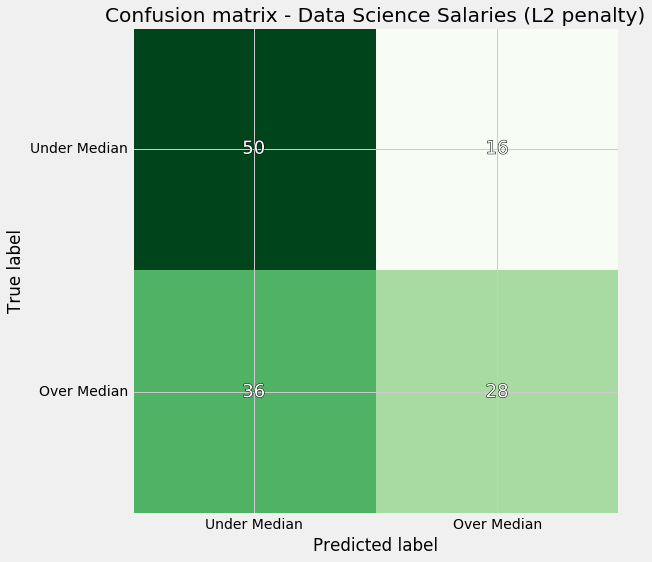

In [119]:
plot_confusion_matrix(cm, title='Confusion matrix - Data Science Salaries (L2 penalty)', labels=['Under Median',\
                                'Over Median'], cmap=plt.cm.Greens)

In [120]:
roc = roc_curve(y, predictions)
roc

(array([ 0.        ,  0.24242424,  1.        ]),
 array([ 0.    ,  0.4375,  1.    ]),
 array([2, 1, 0]))

In [121]:
pred1 = skl_model.predict_proba(X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']]).T[1]
roc = roc_curve(y, pred1)

In [122]:
def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.4, color = 'magenta')
    return

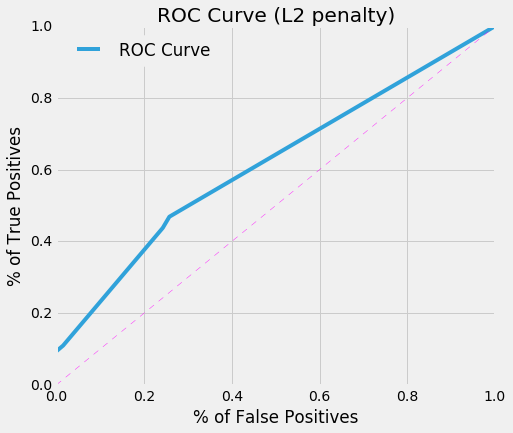

In [123]:
getROCcurve(roc, title='ROC Curve (L2 penalty)', xlabel ='% of False Positives', ylabel = '% of True Positives')

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [124]:
cross_val_score(skl_model, X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']], y, n_jobs=1, cv=5)

array([ 0.66666667,  0.73076923,  0.53846154,  0.46153846,  0.64      ])

In [125]:
score = cross_val_score(skl_model, X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']], y, n_jobs=1, cv=5).mean()

print 'R^2: %s' %score

R^2: 0.607487179487


In [126]:
print 'accuracy: %s' %accuracy_score(y, predictions) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y, predictions) # TP / P
print 'recall: %s' %recall_score(y, predictions) # TP / (TP + FN)
print 'area under curve: %s' %roc_auc_score(y, predictions)

accuracy: 0.6
precision: 0.636363636364
recall: 0.4375
area under curve: 0.597537878788


This model gives us slightly better-than-random predictions about whether a given salary from our list of cities on Indeed.com will fall above or below the threshhold (median) salary.  The model's accuracy -- the rate at which it identies positives and negatives correctly -- is 0.60, or 10% better than random guessing.  Its precision -- the proportion of positives it classifies that are true positives -- is slightly higher, meaning that more of its mistakes must be made in misidentifying the negatives.  Its recall -- the probability that a true positive will be correctly classified -- is pretty low. 

We would want a high-recall model if we needed to be sure of correctly classifying all above-median salaries as such (e.g., misclassifying more geese as planes in order to correctly identify as many planes as possible).  If we didn't need to relocate for a move, for example, we might want to find any jobs that are likely to be over the salary threshhold while at the same time be willing to misclassify some that are below it.  A high-precision model would be useful in this salary scenario if, for example, we were considering relocating for a job and in order to focus our attention needed to be pretty sure that the salary would be over the threshhold.

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

The previous model used L2 penalty (default); here we will use L1:

In [127]:
X_scaled.head()

,stat.,engineer,San Diego,intercept,probability
0,-0.256074,-0.618853,-0.272727,1,0.407864
1,-0.256074,1.615893,-0.272727,1,0.579446
2,-0.256074,1.615893,-0.272727,1,0.579446
3,-0.256074,-0.618853,-0.272727,1,0.407864
4,-0.256074,-0.618853,-0.272727,1,0.407864


In [128]:
del X_scaled['probability']

In [129]:
skl_model_l1 = lm.LogisticRegression(penalty = 'L1')

skl_model_l1.fit(X_scaled, y)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase notation will be removed in 0.18
  DeprecationWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='L1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [130]:
X_scaled['probability'] = skl_model_l1.predict_proba(X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']]).T[1]

In [131]:
predictions = skl_model_l1.predict(X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']])

cm = confusion_matrix(y, predictions)
cm

array([[50, 16],
       [36, 28]])

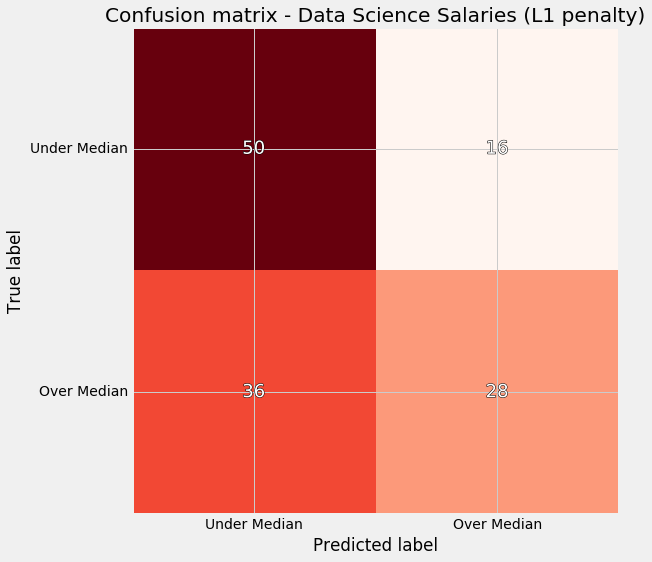

In [132]:
plot_confusion_matrix(cm, title='Confusion matrix - Data Science Salaries (L1 penalty)', labels=['Under Median',\
                                                                'Over Median'], cmap=plt.cm.Reds)

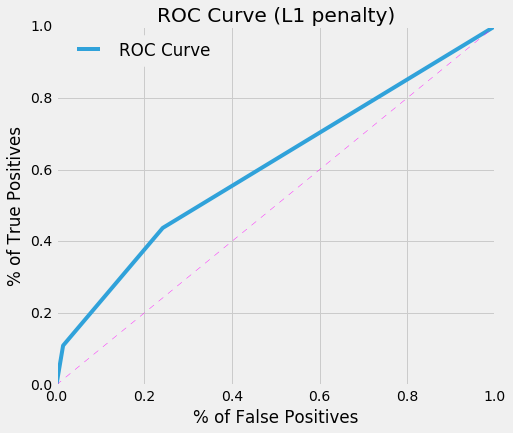

In [133]:
roc = roc_curve(y, predictions)
roc
pred1 = skl_model_l1.predict_proba(X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']]).T[1]
roc = roc_curve(y, pred1)

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.4, color = 'magenta')
    return
getROCcurve(roc, title='ROC Curve (L1 penalty)', xlabel ='% of False Positives', ylabel = '% of True Positives')

In [134]:
cross_val_score(skl_model_l1, X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']], y, n_jobs=1, cv=5)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase notation will be removed in 0.18
  DeprecationWarning)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase notation will be removed in 0.18
  DeprecationWarning)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase notation will be removed in 0.18
  DeprecationWarning)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase not

array([ 0.66666667,  0.73076923,  0.53846154,  0.46153846,  0.64      ])

In [135]:
score = cross_val_score(skl_model_l1, X_scaled[['intercept', 'stat.', 'engineer', 'San Diego']], y, n_jobs=1, cv=5).mean()

print 'R^2: %s' %score

R^2: 0.607487179487


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase notation will be removed in 0.18
  DeprecationWarning)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase notation will be removed in 0.18
  DeprecationWarning)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase notation will be removed in 0.18
  DeprecationWarning)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:874: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase not

In [136]:
print 'accuracy: %s' %accuracy_score(y, predictions) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y, predictions) # TP / P
print 'recall: %s' %recall_score(y, predictions) # TP / (TP + FN)
print 'area under curve: %s' %roc_auc_score(y, predictions)

accuracy: 0.6
precision: 0.636363636364
recall: 0.4375
area under curve: 0.597537878788


L1 vs L2 penalty does not seem to make a difference in the predictions of these models.